In [2]:
pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 5.0 MB/s 
     |████████████████████████████████| 1.4 MB 62.7 MB/s 
     |████████████████████████████████| 233 kB 67.6 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=11481ff1ca59c6382f5b39c585c0b865ccf51fc4efd1473571bb3cc83cb3d3af
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154440 sha256=35fd64c615a5a4c07ae3a725725ed6678f982c68c21eba7c273642bd5712489b
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.preprocessing.sequence import pad_sequences
from __future__ import unicode_literals
from hazm import *
import gc

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Input datasets
I read from 5 datasets and combine them toghether

because of the datasets fault, I can't separate them in file reading time, so I read it as a 1 column

In [ ]:
csv1 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part1.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv2 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part2.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv3 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part3.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
csv4 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part4.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)
#csv5 = pd.read_csv("/content/drive/MyDrive/NerDatas/Persian-NER-part5.txt", header=None, delimiter="~", names = ['All'], encoding_errors = 'ignore', low_memory=False)     #changable

In [ ]:
mainCsv = pd.DataFrame(columns=['All'])
mainCsv = mainCsv.append(csv1, ignore_index=True)
mainCsv = mainCsv.append(csv2, ignore_index=True)
mainCsv = mainCsv.append(csv3, ignore_index=True)
mainCsv = mainCsv.append(csv4, ignore_index=True)
#data = data.append(csv5, ignore_index=True)   #changeable
mainCsv

,All
0,ویکی‌پدیای\tO
1,انگلیسی\tO
2,در\tB-DAT
3,تاریخ\tI-DAT
4,۱۵\tI-DAT
...,...
10527407,روی\tO
10527408,میز\tO
10527409,گزارشگران\tO
10527410,کوبیدند\tO


In [ ]:
tmp = mainCsv['All'].str.rsplit("\t", 1)
dataWord = pd.DataFrame(list(tmp), columns = ['Token', 'NameEntity'])
dataWord

,Token,NameEntity
0,ویکی‌پدیای,O
1,انگلیسی,O
2,در,B-DAT
3,تاریخ,I-DAT
4,۱۵,I-DAT
...,...,...
10527407,روی,O
10527408,میز,O
10527409,گزارشگران,O
10527410,کوبیدند,O


(-1.1033137785109566,
 1.102811138826456,
 -1.1050851919181333,
 1.1002421713451351)

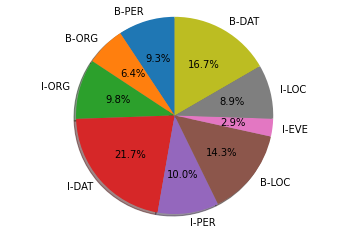

In [ ]:
x = dataWord['NameEntity'].value_counts()[1:-1]
x = shuffle(x)
fig1, ax1 = plt.subplots()
ax1.pie(x.values, labels=x.keys(), autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal') 

In [ ]:
dataWord['NameEntity'].value_counts()

O        8728635
I-DAT     383590
B-DAT     294479
B-LOC     252790
I-PER     178051
I-ORG     174526
B-PER     164234
I-LOC     158827
B-ORG     113397
I-EVE      51561
B-EVE      27310
Name: NameEntity, dtype: int64

In [ ]:
nanIndices = dataWord['NameEntity'][dataWord['NameEntity'].isnull().values].index
nanIndices

Int64Index([ 1193638,  2569124,  2613297,  5508457,  7587616,  8104097,
             8265958,  8566774,  8709133,  8753008,  8968246, 10258056],
           dtype='int64')

In [ ]:
dataWord.iloc[nanIndices]

,Token,NameEntity
1193638,http://turnbull.mcs.st-and.ac.uk/,None
2569124,http://kiau.ac.ir/,None
2613297,2,None
5508457,http://sharif.edu/,None
7587616,members.tripod.com/,None
8104097,http://www.rph.wa.gov.au/,None
8265958,http://sharif.edu/,None
8566774,http://web.eecs.umich.edu/,None
8709133,http://lisa.cs.duke.edu/,None
8753008,http://freepages.genealogy.rootsweb.ancestry.com/,None


In [ ]:
dataWord = dataWord.dropna()
dataWord = dataWord.reset_index(drop = True)

In [ ]:
def makeSentences(dotIndices, data):
  columns = ['Text', 'Label']
  df= []
  begin = 0
  for i in range(len(dotIndices)):
    tmp = data.iloc[begin:dotIndices[i]]
    begin = dotIndices[i] + 1
    _list=[]
    _list.append(' '.join(list(tmp['Token'])))
    _list.append(' '.join(list(tmp['NameEntity'])))
    df.append(_list)
  df= pd.DataFrame(df,columns=list(columns))
  return df

In [ ]:
def bad_token_indices(tokens): #inja / ro ham gozashti khaaaaak 
  bads = []
  badChars = ['(', ')', ' ', '[', ']', '{', '}', ';', ':', '،', '-', '>', '<', '?', '!', '=', '\'', '\"', '@', '#']
  for i in range(len(tokens)):
    for badChar in badChars:
      if(badChar in tokens.iloc[i] and '.' not in tokens.iloc[i]):
        bads.append(i)
        break
  return bads

In [ ]:
badTokenIndices = bad_token_indices(dataWord['Token'])

In [ ]:
np.save('/content/drive/MyDrive/NerDatas/innerInputs/badTokenIndices.np', np.array(badTokenIndices))

In [ ]:
badTokenIndices = np.load('/content/drive/MyDrive/NerDatas/innerInputs/badTokenIndices.np.npy')

In [ ]:
dataWord.drop(labels = badTokenIndices, axis = 0, inplace=True)

In [ ]:
dataWord = dataWord.reset_index(drop = True)

In [ ]:
def calc_average_list  

In [ ]:
def label_to_one_hot(value):
  list_classes = ['O', 'B-DAT', 'I-DAT', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-EVE', 'I-EVE']
  if value == list_classes[0]:
    return [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[1]:
    return [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[2]:
    return [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[3]:
    return [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  if value == list_classes[4]:
    return [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  if value == list_classes[5]:
    return [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  if value == list_classes[6]:
    return [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  if value == list_classes[7]:
    return [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  if value == list_classes[8]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  if value == list_classes[9]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  if value == list_classes[10]:
    return [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
def removeBadSentences(X, Y):
  newX = []
  newY = []
  indices = []
  ind = -1

  for x, y in zip(X, Y):
    ind += 1
    if len(x) == len(y):
      indices.append(ind)
      newX.append(x)
      newY.append(y)

  return newX, newY, indices

In [ ]:
def badPercentage(x, y):
  ind = -1
  notEquallen = 0

  for a,b in zip(x, y):
    ind += 1
    if len(a) != len(b):
      notEquallen += 1

  return notEquallen / len(list_tokenized_train)

In [ ]:
dotIndices = list(dataWord['Token'][dataWord['Token'] == '.'].index)
dataSentences = makeSentences(dotIndices, dataWord)

In [ ]:
dataSentences

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ میل...,O O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT ...
1,بنیان‌گذاران آن جیمی ولز و لری سنگر هستند,O O B-PER I-PER O B-PER I-PER O
2,هم‌اکنون بنیاد غیرانتفاعی بنیاد ویکی‌مدیا پروژ...,O O O B-ORG I-ORG O O O O O
3,کارساز وب اصلی این وبگاه در شهر تامپا ی فلورید...,O O O O O O O B-LOC O B-LOC O
4,همچنین میزبان‌های اضافی دیگری هم در شهرهای آمس...,O O O O O O O B-LOC O B-LOC O O O O O
...,...,...
400326,۲۰۱۳ درگذشت و آندرتیکر و کین برای او مراسم یاد...,O O O B-ORG I-ORG I-ORG O O O O O
400327,در تاریخ ۲۳ ژوئیه ۲۰۱۲ در‌حین اجرای شوی WWE را...,B-DAT I-DAT B-DAT I-DAT I-DAT O O O O O O O O ...
400328,در سال بعد ۲۰۱۳ کمی قبل از رستلمنیا ۲۹ پول بیر...,B-DAT B-DAT I-DAT O O O O B-EVE I-EVE O O O O ...
400329,در رستلمنیا ۲۹ یک مسابقه بین آندرتیکر و CM پان...,O B-EVE I-EVE O O O O O O O O O O O O O O O O ...


## Split data into X and y

In [ ]:
yLabel = dataSentences['Label']
sentences = dataSentences['Text']

## Tokenization

In [ ]:
max_features = 750025   # changeable
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(sentences))
list_tokenized_train = tokenizer.texts_to_sequences(sentences)

y = [[label_to_one_hot(c) for c in ey.split(' ')] for ey in yLabel]

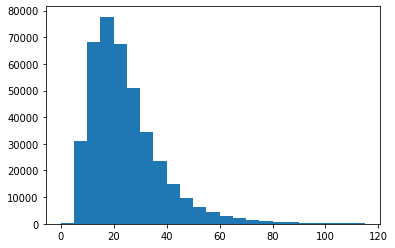

In [ ]:
senLens = [len(sen) for sen in list_tokenized_train]
plt.hist(senLens, bins = np.arange(0,120,5))
plt.show()

## Find bad Sentences and remove them 

In [ ]:
badPercentage(list_tokenized_train, y)

0.0

In [ ]:
list_tokenized_train, y, goodIndices = removeBadSentences(list_tokenized_train, y)

In [ ]:
badPercentage(list_tokenized_train, y)

0.0

In [ ]:
dataWord = dataWord.iloc[goodIndices]              #run once...
dataSentenses = dataSentenses.iloc[goodIndices]

In [ ]:
dataSentenses = dataSentenses.reset_index(drop = True)

In [ ]:
sentences = sentences.iloc[goodIndices]            #run once...


In [ ]:
dataSentences = dataSentences.iloc[goodIndices]     #run once...

In [ ]:
dataSentences = dataSentences.reset_index(drop = True)  #run once...

In [ ]:
dataSentences

In [ ]:
len(sentences)

390935

In [ ]:
senLens = [len(sen) for sen in list_tokenized_train]
len(senLens)

390935

400331

In [ ]:
senInfo = pd.DataFrame()
senInfo['Lens'] = senLens
senInfo['O_Count'] = list(dataSentences['Label'].str.count('O'))
senInfo

,Lens,O_Count
0,20,11
1,8,4
2,10,10
3,11,11
4,15,15
...,...,...
390930,11,11
390931,45,40
390932,30,25
390933,28,25


In [ ]:
senInfo['NE_Count'] = senInfo['Lens'] - senInfo['O_Count']
senInfo

,Lens,O_Count,NE_Count
0,20,11,9
1,8,4,4
2,10,10,0
3,11,11,0
4,15,15,0
...,...,...,...
390930,11,11,0
390931,45,40,5
390932,30,25,5
390933,28,25,3


In [ ]:
senInfo.describe()

,Lens,O_Count,NE_Count,NE/Len
count,390935.000000,390935.000000,390935.000000,390935.000000
mean,24.030673,21.317314,2.713359,12.791833
std,14.578518,14.009967,3.024846,13.908008
min,1.000000,0.000000,0.000000,0.000000
25%,14.000000,12.000000,0.000000,0.000000
50%,21.000000,18.000000,2.000000,9.756098
75%,30.000000,27.000000,4.000000,20.000000
max,788.000000,727.000000,127.000000,100.000000


In [ ]:
senInfo['NE/Len'] = senInfo['NE_Count'] / (senInfo['Lens']) * 100

In [ ]:
def balanced_sen(NE_divide_Len, NE_Count, percent = 8, least_count = 3):
  balancedIndices = []
  ind = -1
  for neC, neD in zip(NE_divide_Len, NE_Count):
    ind += 1
    if neC >= percent or neD > least_count:
      balancedIndices.append(ind)
  return balancedIndices

In [ ]:
balanced_indices = balanced_sen(senInfo['NE/Len'], senInfo['NE_Count'])

In [ ]:
senInfo.iloc[balanced_indices]

,Lens,O_Count,NE_Count,NE/Len
0,20,11,9,45.000000
1,8,4,4,50.000000
5,28,24,4,14.285714
6,29,24,5,17.241379
8,22,13,9,40.909091
...,...,...,...,...
390928,20,12,8,40.000000
390929,35,30,5,14.285714
390931,45,40,5,11.111111
390932,30,25,5,16.666667


In [ ]:
dataSentences

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ میل...,O O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT ...
1,بنیان‌گذاران آن جیمی ولز و لری سنگر هستند,O O B-PER I-PER O B-PER I-PER O
2,هم‌اکنون بنیاد غیرانتفاعی بنیاد ویکی‌مدیا پروژ...,O O O B-ORG I-ORG O O O O O
3,کارساز وب اصلی این وبگاه در شهر تامپا ی فلورید...,O O O O O O O B-LOC O B-LOC O
4,همچنین میزبان‌های اضافی دیگری هم در شهرهای آمس...,O O O O O O O B-LOC O B-LOC O O O O O
...,...,...
390930,۲۰۱۳ درگذشت و آندرتیکر و کین برای او مراسم یاد...,O O O B-ORG I-ORG I-ORG O O O O O
390931,در تاریخ ۲۳ ژوئیه ۲۰۱۲ در‌حین اجرای شوی WWE را...,B-DAT I-DAT B-DAT I-DAT I-DAT O O O O O O O O ...
390932,در سال بعد ۲۰۱۳ کمی قبل از رستلمنیا ۲۹ پول بیر...,B-DAT B-DAT I-DAT O O O O B-EVE I-EVE O O O O ...
390933,در رستلمنیا ۲۹ یک مسابقه بین آندرتیکر و CM پان...,O B-EVE I-EVE O O O O O O O O O O O O O O O O ...


In [ ]:
dataSentences = dataSentences.iloc[balanced_indices]
dataSentences = dataSentences.reset_index(drop = True)

In [ ]:
dataSentences

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ میل...,O O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT ...
1,بنیان‌گذاران آن جیمی ولز و لری سنگر هستند,O O B-PER I-PER O B-PER I-PER O
2,ویکی‌پدیا از پایان آوریل ۲۰۰۷ تاکنون یکی از ۱۰...,O B-DAT I-DAT I-DAT I-DAT O O O O O O O O O O ...
3,در میان تمام زبان‌های ویکی‌پدیا تا دسامبر ۲۰۱۵...,O O O O O B-DAT I-DAT I-DAT B-DAT I-DAT O O O ...
4,نوپدیا در تاریخ ۹ مارس ۲۰۰۰ میلادی ۱۹ اسفند ۱۳...,O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT I-...
...,...,...
216515,پس‌از‌آن دیگر آندرتیکر حضور نیافت تا سال بعد ک...,O O O O O B-DAT I-DAT I-DAT O O B-EVE I-EVE I-...
216516,حضور نیافت تا‌این‌که در سال ۲۰۱۲ برای حمایت دو...,O O O B-DAT B-DAT I-DAT O O O O O O B-PER I-PE...
216517,در تاریخ ۲۳ ژوئیه ۲۰۱۲ در‌حین اجرای شوی WWE را...,B-DAT I-DAT B-DAT I-DAT I-DAT O O O O O O O O ...
216518,در سال بعد ۲۰۱۳ کمی قبل از رستلمنیا ۲۹ پول بیر...,B-DAT B-DAT I-DAT O O O O B-EVE I-EVE O O O O ...


In [ ]:
senInfo

,Lens,O_Count,NE_Count,NE/Len
0,20,11,9,45.000000
1,8,4,4,50.000000
2,10,10,0,0.000000
3,11,11,0,0.000000
4,15,15,0,0.000000
...,...,...,...,...
390930,11,11,0,0.000000
390931,45,40,5,11.111111
390932,30,25,5,16.666667
390933,28,25,3,10.714286


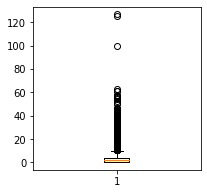

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(3, 3))
plt.boxplot(senInfo['NE_Count'])
plt.show()

In [ ]:
dataSentences.to_csv('/content/drive/MyDrive/NerDatas/innerInputs/dataSentences')

In [5]:
dataSentences = pd.read_csv('/content/drive/MyDrive/NerDatas/innerInputs/dataSentences2')

In [ ]:
dataSentences.to_csv('/content/drive/MyDrive/NerDatas/innerInputs/dataSentences2')

In [6]:
dataSentences = dataSentences[['Text', 'Label']]

In [7]:
dataSentences

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ میل...,O O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT ...
1,بنیان‌گذاران آن جیمی ولز و لری سنگر هستند,O O B-PER I-PER O B-PER I-PER O
2,ویکی‌پدیا از پایان آوریل ۲۰۰۷ تاکنون یکی از ۱۰...,O B-DAT I-DAT I-DAT I-DAT O O O O O O O O O O ...
3,در میان تمام زبان‌های ویکی‌پدیا تا دسامبر ۲۰۱۵...,O O O O O B-DAT I-DAT I-DAT B-DAT I-DAT O O O ...
4,نوپدیا در تاریخ ۹ مارس ۲۰۰۰ میلادی ۱۹ اسفند ۱۳...,O B-DAT I-DAT I-DAT I-DAT I-DAT B-DAT B-DAT I-...
...,...,...
216515,پس‌از‌آن دیگر آندرتیکر حضور نیافت تا سال بعد ک...,O O O O O B-DAT I-DAT I-DAT O O B-EVE I-EVE I-...
216516,حضور نیافت تا‌این‌که در سال ۲۰۱۲ برای حمایت دو...,O O O B-DAT B-DAT I-DAT O O O O O O B-PER I-PE...
216517,در تاریخ ۲۳ ژوئیه ۲۰۱۲ در‌حین اجرای شوی WWE را...,B-DAT I-DAT B-DAT I-DAT I-DAT O O O O O O O O ...
216518,در سال بعد ۲۰۱۳ کمی قبل از رستلمنیا ۲۹ پول بیر...,B-DAT B-DAT I-DAT O O O O B-EVE I-EVE O O O O ...


## Tokenizationnnnn

In [ ]:
yLabel = dataSentences['Label']
sentences = dataSentences['Text']

In [ ]:
max_features = 550025   # changeable
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(sentences))
list_tokenized_train = tokenizer.texts_to_sequences(sentences)

y = [[label_to_one_hot(c) for c in ey.split(' ')] for ey in yLabel]

## Padding

In [ ]:
maxlen = 60
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y_t = pad_sequences(y, maxlen=maxlen)
print(len(X_t[0]))
print(len(y_t[0]))

60
60


## Embedding

In [ ]:
def loadEmbeddingMatrix(typeToLoad):
    if(typeToLoad=="fasttext"):
        EMBEDDING_FILE='/content/drive/MyDrive/NerDatas/cc.fa.300.vec'
        embed_size = 300

    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        with open(EMBEDDING_FILE,'r', encoding='utf8')as f:
            for line in f:
                try:
                    values = line.split()

                    if len(values)==301:
                        word = values[0]    
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==302:
          #print(len(value))
                        word = values[0]+'\u200c'+values[1]   
                        coefs = np.asarray(values[2:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==303:
                        word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]  
                        coefs = np.asarray(values[3:], dtype='float32')
                        embeddings_index[word] = coefs
                except Exception as inst:
                        print(inst)
    else:
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            #print('Loaded %s word vectors.' % len(embeddings_index))
                        
    gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
    nb_words = len(tokenizer.word_index)
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')
        
    del(embeddings_index)
    gc.collect()
        
        #finally, return the embedding matrix
    return embedding_matrix

In [ ]:
embedding_matrix = loadEmbeddingMatrix('fasttext') #we use the lower line instead of runing several times 

total embedded: 118485 common words


In [ ]:
np.save('/content/drive/MyDrive/NerDatas/Embedding/embedding_matrix.csv2.npy', embedding_matrix)

In [ ]:
embedding_matrix = np.load('/content/drive/MyDrive/NerDatas/Embedding/embedding_matrix.csv2.npy')

In [ ]:
#embedding_matrix = np.load('/content/drive/MyDrive/NerDatas/Embedding/embedding_matrix.csv.npy')

## 

In [ ]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-c00gvgyf
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-c00gvgyf


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.1, random_state=21)

In [ ]:
from keras.layers import  TimeDistributed, Masking, Conv1D, MaxPooling1D, Flatten
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy, crf_accuracy
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras import backend as K

model = Sequential()
# model.add(Dense(shape=(maxlen,)))
model.add(Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],
                    weights=[embedding_matrix],trainable=False ))
model.add(Bidirectional(LSTM(200, return_sequences=True,
                             name='lstm_layer1', dropout=0.1, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(300, return_sequences=True,
                              name='lstm_layer2', dropout=0.1, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(300, return_sequences=True,
                              name='lstm_layer3', dropout=0.1, recurrent_dropout=0.1)))
model.add(Bidirectional(LSTM(200, return_sequences=True,
                              name='lstm_layer4', dropout=0.1, recurrent_dropout=0.1)))
model.add(Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         40960500  
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 400)        801600    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 600)        1682400   
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 600)        2162400   
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, None, 400)        1281600   
 nal)                                                 

In [ ]:
batch_size = 512
epochs = 4
filepath="/content/drive/MyDrive/NerDatas/check_point/check_point5.model"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,callbacks=callbacks_list, validation_split=0.15)

Epoch 1/4
324/324 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8995 - precision_1: 0.7767 - recall_1: 0.6996
Epoch 1: val_accuracy improved from -inf to 0.91721, saving model to /content/drive/MyDrive/NerDatas/check_point/check_point5.model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/NerDatas/check_point/check_point5.model/assets


324/324 [==============================] - 715s 2s/step - loss: 0.3891 - accuracy: 0.8995 - precision_1: 0.7767 - recall_1: 0.6996 - val_loss: 0.3262 - val_accuracy: 0.9172 - val_precision_1: 0.8227 - val_recall_1: 0.7267
Epoch 2/4
324/324 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.9236 - precision_1: 0.8368 - recall_1: 0.7598
Epoch 2: val_accuracy improved from 0.91721 to 0.93090, saving model to /content/drive/MyDrive/NerDatas/check_point/check_point5.model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/NerDatas/check_point/check_point5.model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NerDatas/check_point/check_point5.model/assets


324/324 [==============================] - 698s 2s/step - loss: 0.2821 - accuracy: 0.9236 - precision_1: 0.8368 - recall_1: 0.7598 - val_loss: 0.2391 - val_accuracy: 0.9309 - val_precision_1: 0.8462 - val_recall_1: 0.7895
Epoch 3/4
324/324 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.9341 - precision_1: 0.8630 - recall_1: 0.7894
Epoch 3: val_accuracy improved from 0.93090 to 0.94125, saving model to /content/drive/MyDrive/NerDatas/check_point/check_point5.model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/NerDatas/check_point/check_point5.model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NerDatas/check_point/check_point5.model/assets


324/324 [==============================] - 670s 2s/step - loss: 0.2203 - accuracy: 0.9341 - precision_1: 0.8630 - recall_1: 0.7894 - val_loss: 0.1898 - val_accuracy: 0.9413 - val_precision_1: 0.8773 - val_recall_1: 0.8119
Epoch 4/4
324/324 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9430 - precision_1: 0.8798 - recall_1: 0.8195
Epoch 4: val_accuracy improved from 0.94125 to 0.94824, saving model to /content/drive/MyDrive/NerDatas/check_point/check_point5.model
INFO:tensorflow:Assets written to: /content/drive/MyDrive/NerDatas/check_point/check_point5.model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NerDatas/check_point/check_point5.model/assets


324/324 [==============================] - 723s 2s/step - loss: 0.1836 - accuracy: 0.9430 - precision_1: 0.8798 - recall_1: 0.8195 - val_loss: 0.1649 - val_accuracy: 0.9482 - val_precision_1: 0.8872 - val_recall_1: 0.8405


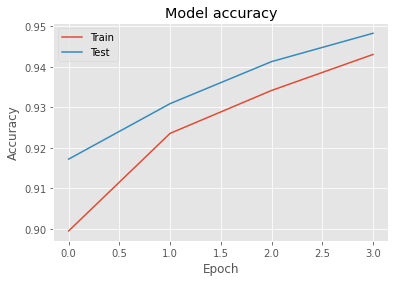

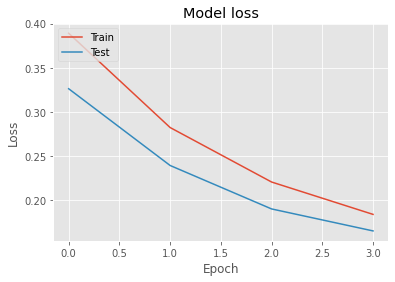

In [ ]:
# Visualize the Model
plt.style.use("ggplot")
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred.shape, y_test.shape

((21652, 60, 11), (21652, 60, 11))

In [ ]:
y_pred.flatten()

array([1.9285795e-01, 7.2726339e-02, 5.4379821e-02, ..., 3.6879751e-04,
       1.2027302e-04, 2.3335488e-04], dtype=float32)

In [ ]:
np.argmax(y_pred[116], axis = 1) ,np.argmax(y_test[116], axis = 1)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
y_predC = []
y_testC = []
for pred,test in zip(y_pred, y_test):
  y_predC.append(np.argmax(pred, axis = 1))
  y_testC.append(np.argmax(test, axis = 1))
y_predC = np.array(y_predC)
y_testC = np.array(y_testC)

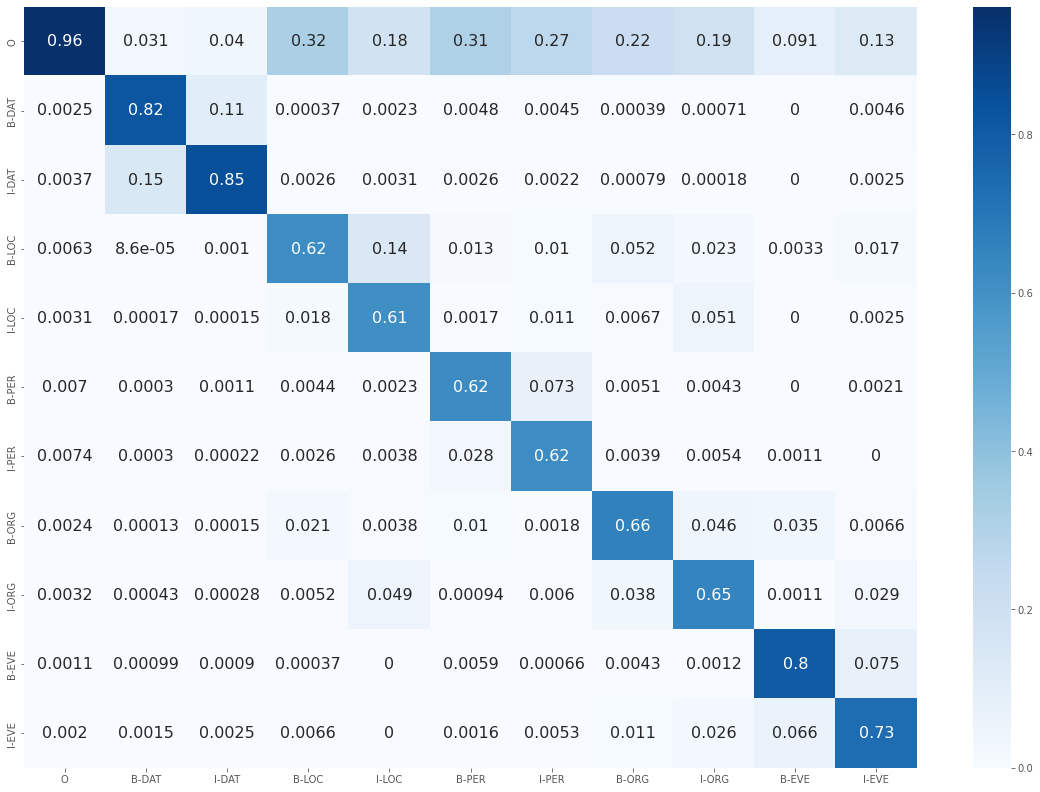

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn
target_names = ['O', 'B-DAT', 'I-DAT', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-EVE', 'I-EVE']
cfnMatrix = confusion_matrix(y_testC.flatten(), y_predC.flatten())
df_cm = pd.DataFrame(cfnMatrix / np.sum(cfnMatrix, axis=0 ), index = target_names,columns = target_names)
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues") #, vmin=0, vmax=2000

In [ ]:
np.sort(cfnMatrix) / np.sum(cfnMatrix, axis=1 )

array([[     84,     240,     308,     550,     727,     868,    1074,
           1285,    2315,    2822, 1163139],
       [      0,       1,       1,       3,       4,      11,      36,
             48,    3079,    3478,   18998],
       [      0,       1,       2,       4,       6,       7,      19,
             23,    3387,    4430,   27426],
       [      2,       3,      34,      41,      97,     107,     128,
            132,     183,    1674,    7669],
       [      0,       4,       5,       6,      13,      17,      48,
            113,     284,     797,    3799],
       [      0,       3,       5,       7,      12,      13,      24,
             35,     776,    4611,    8415],
       [      0,       1,       5,       7,       7,       7,      10,
             30,     207,    6550,    8962],
       [      3,       5,       5,      16,      19,      32,      57,
             78,     260,    1683,    2948],
       [      1,       7,       9,      10,      14,      63,      64,
 

In [ ]:
from sklearn.metrics import classification_report
target_names = ['O', 'B-DAT', 'I-DAT', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-EVE', 'I-EVE']
print(classification_report(y_testC.flatten(), y_predC.flatten(), target_names=target_names))

              precision    recall  f1-score   support

           O       0.96      0.99      0.98   1173412
       B-DAT       0.82      0.74      0.78     25659
       I-DAT       0.85      0.78      0.81     35305
       B-LOC       0.62      0.17      0.26     10070
       I-LOC       0.61      0.16      0.25      5086
       B-PER       0.62      0.33      0.43     13901
       I-PER       0.62      0.41      0.50     15786
       B-ORG       0.66      0.33      0.44      5106
       I-ORG       0.65      0.47      0.54      7823
       B-EVE       0.80      0.31      0.45      2360
       I-EVE       0.73      0.38      0.50      4612

    accuracy                           0.95   1299120
   macro avg       0.72      0.46      0.54   1299120
weighted avg       0.94      0.95      0.94   1299120



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
target_names = ['O', 'B-DAT', 'I-DAT', 'B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-EVE', 'I-EVE']
cnf = multilabel_confusion_matrix(y_testC, y_predC)

ValueError: ignored

In [ ]:
type(y_predC)

list

In [ ]:
dotIndices = list(data1['Token'][data1['Token'] == '.'].index)

In [ ]:
type(dotIndices)

list

In [ ]:
def makeSentences(dotIndices, data):
  columns = ['Text', 'Label']
  df= []
  begin = 0
  for i in range(len(dotIndices)-100):
    tmp = data.iloc[begin:dotIndices[i]]
    begin = dotIndices[i] + 1
    _list=[]
    _list.append(' '.join(list(tmp['Token'])))
    _list.append(' '.join(list(tmp['NameEntity'])))
    df.append(_list)
  df= pd.DataFrame(df,columns=list(columns))
  return df

In [ ]:
makeSentences(dotIndices, data1)

,Text,Label
0,ویکی‌پدیای انگلیسی در تاریخ ۱۵ ژانویه ۲۰۰۱ ( م...,O O B-DAT I-DAT I-DAT I-DAT I-DAT O B-DAT O B-...
1,بنیان‌گذاران آن ، جیمی ولز و لری سنگر هستند,O O O B-PER I-PER O B-PER I-PER O
2,هم‌اکنون بنیاد غیرانتفاعی بنیاد ویکی‌مدیا پروژ...,O O O B-ORG I-ORG O O O O O
3,کارساز وب اصلی این وبگاه در شهر تامپا ی فلورید...,O O O O O O O B-LOC O B-LOC O
4,همچنین میزبان‌های اضافی دیگری هم در شهرهای آمس...,O O O O O O O B-LOC O B-LOC O O O O O
...,...,...
98721,روز یکشنبه ۲۵ دی‌ماه ۱۳۹۰ ماموران امنیتی او را...,B-DAT I-DAT I-DAT O O O O O O O O O B-LOC O O ...
98722,او در تاریخ ۷ اسفند ۱۳۹۰ به قید وثیقه آزاد شد,O B-DAT I-DAT I-DAT I-DAT I-DAT O O O O O
98723,هنریک یوهان ایبسن ( زاده ۲۰ مارس ۱۸۲۸ در شین (...,O O O O O B-DAT I-DAT I-DAT O O O O O B-LOC B-...
98724,او یکی از بزرگ‌ترین استادان هنر تئاتر در تمامی...,O O O O O O O O O O O O O O B-PER O O


In [ ]:
data1.iloc[[1193638]]

,Token,NameEntity
1193638,در,O


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz

--2022-08-01 08:47:55--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fa.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1258183862 (1.2G) [binary/octet-stream]
Saving to: ‘cc.fa.300.vec.gz’

cc.fa.300.vec.gz    100%[===================>]   1.17G  24.4MB/s    in 47s     

2022-08-01 08:48:43 (25.4 MB/s) - ‘cc.fa.300.vec.gz’ saved [1258183862/1258183862]



In [ ]:
!gunzip cc.fa.300.vec.gz

In [ ]:
!mv cc.fa.300.vec /content/drive/MyDrive/NerDatas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

drive  sample_data


drive/  sample_data/


In [ ]:
normalizer = Normalizer()
normalizer.normalize('اصلاح نويسه ها و استفاده از نیم‌فاصله پردازش را آسان مي كند')

'اصلاح نویسه\u200cها و استفاده از نیم\u200cفاصله پردازش را آسان می\u200cکند'

In [ ]:
print(sentences[3])
normalizer.normalize(sentences[3])

کارساز وب اصلی این وبگاه در شهر تامپا ی فلوریدا هستند


'کارساز وب اصلی این وبگاه در شهر تامپا ی فلوریدا هستند'

In [ ]:
stemmer = Stemmer()
lemmatizer = Lemmatizer()

In [ ]:
lemmatizer.lemmatize('می‌روم')

'رفت#رو'

In [ ]:
lemmatizer.lemmatize(sentences[3])

'کارساز وب اصلی این وبگاه در شهر تامپا ی فلوریدا هستند'

In [ ]:
list_tokenized_train[1]

[7412, 21, 8, 4758, 2951, 4, 5334, 8250, 113]

In [ ]:
sentences[1]

'بنیان\u200cگذاران آن ، جیمی ولز و لری سنگر هستند'

In [ ]:
a = dataWord['Token'][dataWord['Token'] == 'رویزیونیسم'].index

In [ ]:
dataWord.iloc[a[1] : a[1] + 19]

,Token,NameEntity
683244,رویزیونیسم,O
683245,می‌خوانند,O
683246,.,O
683247,استالین,O
683248,در,O
683249,۱۹۲۸,O
683250,سیاست,O
683251,نپ,O
683252,"( , ،",O
683253,سیاست,O


In [ ]:
a = -1
for i in dotIndices:
  a += 1
  if i == 683246:
    print(a)

25777


In [ ]:
dotIndices[25777]

683246

In [ ]:
sentences[25778].split()

In [ ]:
ind = -1
notEquallen = 0
badSentenceIndices = []
for a,b in zip(list_tokenized_train, y):
  ind += 1
  if len(a) != len(b):
    badSentenceIndices.append(ind)
    notEquallen += 1
notEquallen / len(list_tokenized_train)

99941

In [ ]:
notEquallen / len(list_tokenized_train)

0.24964591800285263

list

In [ ]:
len(list_tokenized_train[25778])

24

In [ ]:
len(y[25778])

25

In [ ]:
badSentenceIndices

[0,
 6,
 8,
 11,
 12,
 16,
 20,
 21,
 24,
 25,
 26,
 27,
 29,
 30,
 32,
 33,
 34,
 58,
 59,
 61,
 62,
 70,
 71,
 72,
 74,
 75,
 77,
 83,
 84,
 86,
 87,
 88,
 89,
 91,
 92,
 97,
 104,
 109,
 120,
 122,
 130,
 137,
 144,
 148,
 150,
 155,
 157,
 158,
 159,
 163,
 178,
 189,
 191,
 195,
 203,
 206,
 215,
 217,
 219,
 220,
 223,
 242,
 244,
 247,
 249,
 251,
 253,
 254,
 257,
 260,
 263,
 264,
 267,
 270,
 281,
 283,
 289,
 301,
 305,
 317,
 318,
 337,
 349,
 352,
 353,
 355,
 357,
 366,
 368,
 370,
 376,
 377,
 381,
 388,
 389,
 390,
 393,
 403,
 404,
 410,
 424,
 441,
 443,
 444,
 446,
 452,
 453,
 454,
 456,
 458,
 459,
 460,
 463,
 465,
 475,
 479,
 482,
 484,
 494,
 495,
 502,
 507,
 511,
 514,
 517,
 519,
 526,
 529,
 530,
 533,
 536,
 539,
 542,
 543,
 544,
 545,
 546,
 548,
 549,
 551,
 555,
 556,
 557,
 558,
 560,
 566,
 568,
 570,
 572,
 575,
 576,
 577,
 580,
 585,
 589,
 593,
 598,
 599,
 604,
 608,
 612,
 634,
 635,
 640,
 643,
 649,
 651,
 654,
 656,
 663,
 665,
 666,
 672,
 